<a href="https://colab.research.google.com/github/pachterlab/BLCSBGLKP_2020/blob/master/notebooks/kb_v_starcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Mon May 11 06:08:48 UTC 2020


In [2]:
!git clone https://github.com/pachterlab/BLCSBGLKP_2020.git

Cloning into 'BLCSBGLKP_2020'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 178 (delta 53), reused 75 (delta 10), pack-reused 0
Receiving objects: 100% (178/178), 33.74 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [3]:
!pip install anndata

     |████████████████████████████████| 102kB 2.7MB/s 


# KB v starcode

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from scipy import stats
import anndata
from collections import defaultdict

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [0]:
kb = anndata.read_h5ad("BLCSBGLKP_2020/data/kb/adata.h5ad")

In [6]:
kb.var

,gene
0,N1
1,N1_spikein
2,RPP30
3,S2
4,S2_spikein


In [0]:
gene_map = {'SARS-CoV-2_S':"S2" ,
            'SARS-CoV-2_S_spikein':"S2_spike" ,
            'SARS-CoV-2_N':"N1",
            'SARS-CoV-2_N_spikein':"N1_spike" ,
            'RPP30':"RPP30"}

In [0]:
gene_map = {'S2':"S2" ,
            'S2_spikein':"S2_spike" ,
            'N1':"N1",
            'N1_spikein':"N1_spike" ,
            'RPP30':"RPP30"}

In [0]:
kb.var["sm_gene"] = kb.var["gene"].map(gene_map)
kb.obs["sid"] = kb.obs.plate.astype(str) + "-" + kb.obs.well.astype(str)

In [0]:
sm = pd.read_csv("BLCSBGLKP_2020/data/starcode/starcode_count_mtx.txt", sep="\t")

In [0]:
obs = sm.loc[:,"Sample_ID"].values
var = sm.loc[:,"N1":].columns.values
mtx = sm.loc[:,"N1":].values
sm = anndata.AnnData(X=mtx, obs={"sid":obs}, var={"gene":var})

In [12]:
sm

AnnData object with n_obs × n_vars = 768 × 5 
    obs: 'sid'
    var: 'gene'

In [0]:
sm = sm[sm.obs.sort_values("sid").index]
sm = sm[:,sm.var.sort_values("gene").index]

kb = kb[kb.obs.sort_values("sid").index]
kb = kb[:,kb.var.sort_values("sm_gene").index]

# Compare

In [0]:
g = ["RPP30",
"S2",
"S2_spike"]

In [0]:
import matplotlib as mpl

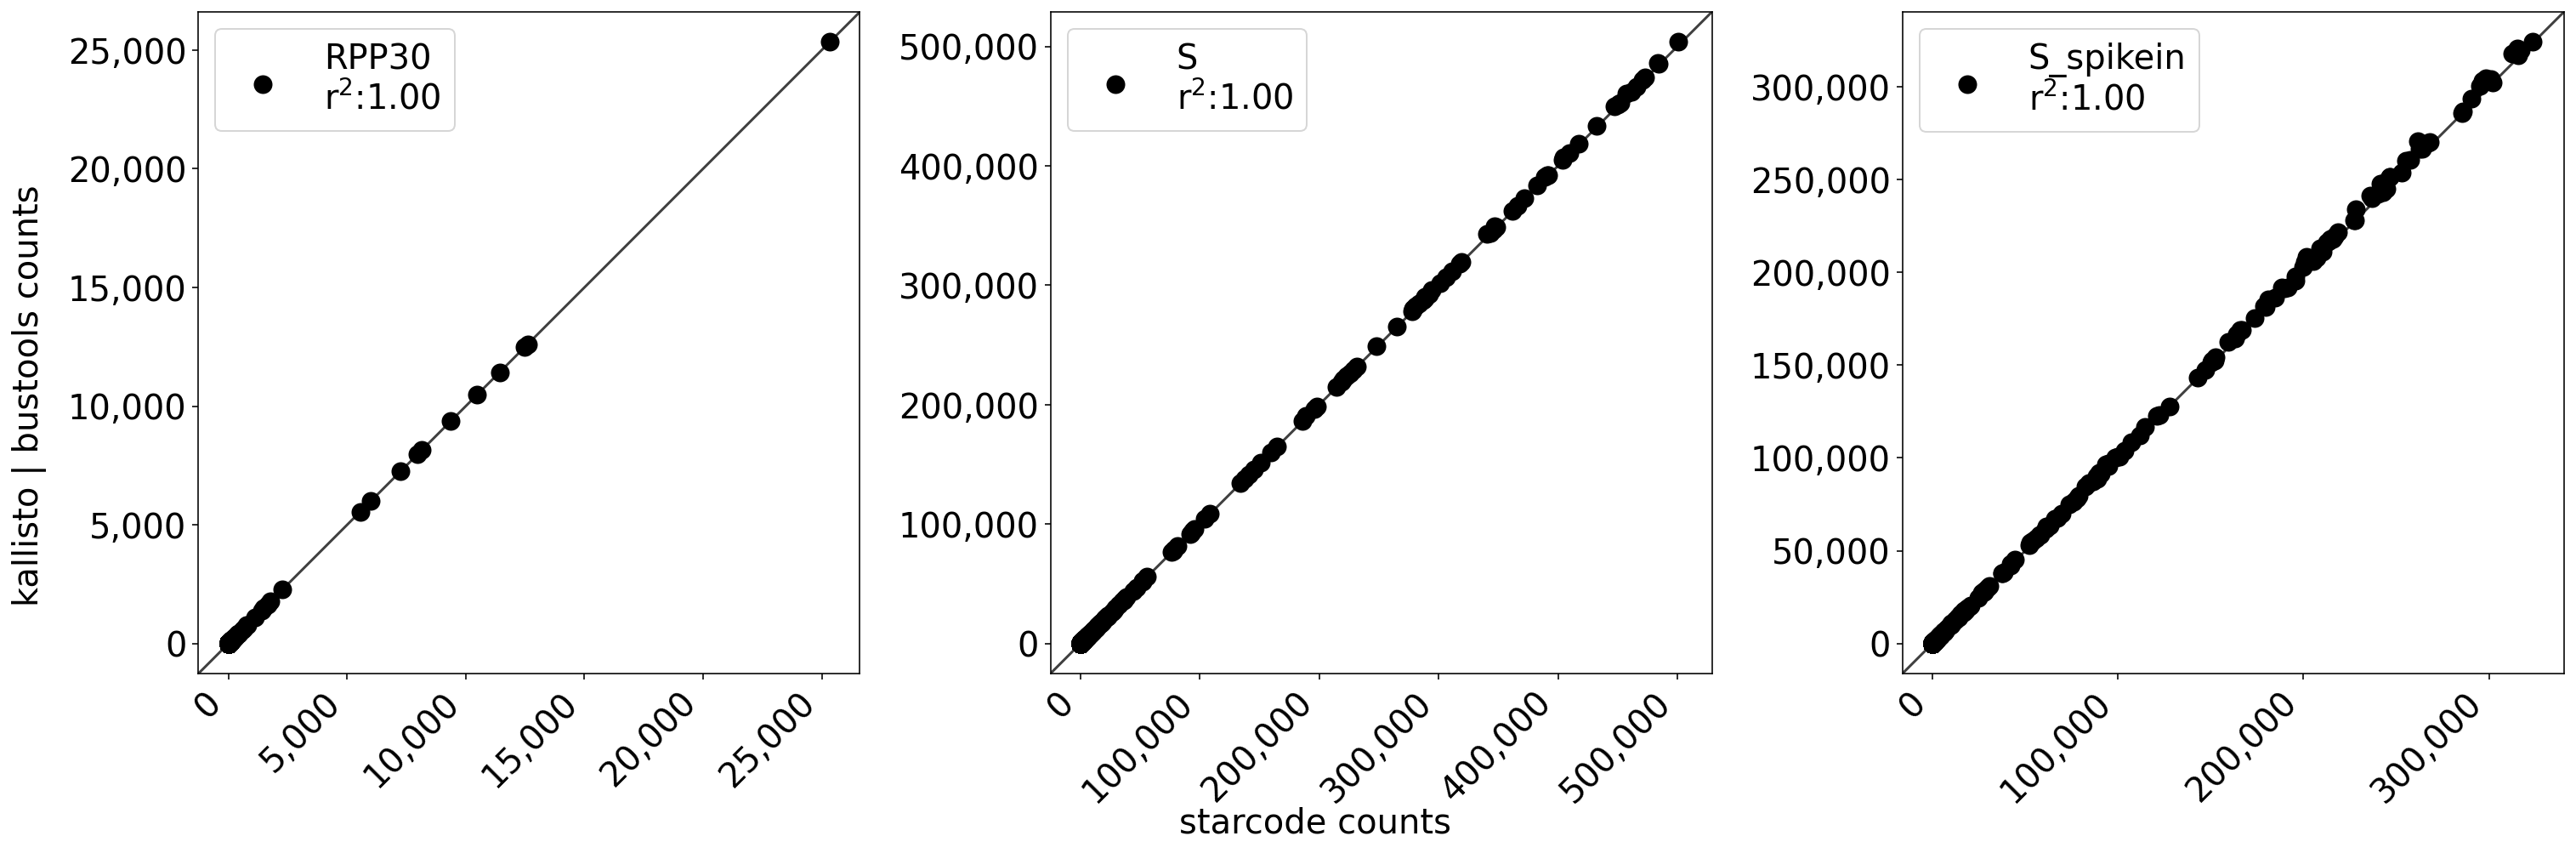

In [16]:
fig, ax = plt.subplots(figsize=(7*3,7), ncols=3)
axs = trim_axs(ax, len(kb.var.sm_gene.values))


for gidx, (ax, gene) in enumerate(zip(axs, g)):
    kb_gidx = np.where(kb.var.sm_gene.values==gene)[0][0]
    sm_gidx = np.where(sm.var.gene.values==gene)[0][0]
    x = nd(sm.X[:,sm_gidx])
    y = nd(kb.layers["raw"][:,kb_gidx])
    #c = (y>250000).astype(int)
    
    r, p = stats.pearsonr(x, y)
    
    if gene=="S2":
        gene = "S"
    elif gene == "S2_spike":
        gene="S_spikein"
    
    ax.scatter(x, y, color="k", s=100,  label="{}\nr$^2$:{:,.2f}".format(gene, r**2))
    
    yex(ax)
    #ax.set_axis_off()
    ax.legend(loc="upper left")

    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
fig.text(0.5, 0, 'starcode counts', ha='center', va='center', fontsize=20)
fig.text(0, 0.5, 'kallisto | bustools counts', ha='center', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
#plt.savefig("./figs/kb_v_starcode.png",bbox_inches='tight', dpi=300)
plt.show()

In [17]:
sm.X.sum()

ArrayView(74934750., dtype=float32)

In [18]:
kb.layers["raw"].sum()

ArrayView(75500420., dtype=float32)